<a href="https://colab.research.google.com/github/footynavinho/striker-recruitment-model/blob/main/python/striker_recruitment_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os

os.makedirs("data", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

In [10]:
import os
os.listdir("data")

['strikers_raw.csv']

In [11]:
import pandas as pd
import numpy as np

In [12]:
#Importing Raw Data CSV File

df = pd.read_csv("/content/data/strikers_raw.csv")
df.head()

,Player,Squad,Age,Minutes,Shots_90,xG_90,npxG_90,Touches_Box_90,Shots_per_Touch,Aerials_Won_Pct,...,Fouls_Drawn_90,SoT_Pct,Avg_Shot_Distance,G_minus_xG,Passes_Received_90,Key_Passes_90,Prog_Passes_Received_90,Prog_Carries_90,Carry_Distance_90,Carries_Into_Box_90
0,Elijah Adebayo,Luton Town,25,1419,1.97,0.37,0.37,5.19,0.38,50.0,...,1.01,45.2,9.6,4.1,21.3,14,110,1.01,26.9,13
1,Simon Adingra,Brighton,21,2222,2.11,0.17,0.17,6.19,0.34,40.0,...,0.77,42.3,15.9,1.7,32.2,33,278,4.49,121.3,63
2,Miguel Almirón,Newcastle Utd,29,1937,1.91,0.21,0.21,4.00,0.48,46.2,...,1.02,29.3,16.1,-1.5,34.5,24,162,3.63,105.9,22
3,Zeki Amdouni,Burnley,22,1953,2.21,0.27,0.23,3.13,0.71,21.1,...,1.80,43.8,17.8,-0.8,23.6,16,93,2.90,76.2,20
4,Michail Antonio,West Ham,33,1695,1.59,0.31,0.31,3.14,0.51,38.4,...,1.49,46.7,13.1,0.2,21.2,8,104,2.55,57.7,19


In [13]:
# RAW DATA
# Identify valuable statistics to assess a forward's contribution to the game
# Normalize all statistics for 23/24 Premier League forwards against their peers

metrics = [
    "Shots_90", "xG_90", "Touches_Box_90",
    "Shots_per_Touch", "npxG_90",
    "Aerials_Won_90", "Fouls_Drawn_90",
    "Passes_Received_90", "Prog_Passes_Received_90",
    "Prog_Carries_90", "Carries_Into_Box_90"
]

for m in metrics:
    df[m + "_pct"] = df[m].rank(pct=True)

In [14]:
# ARCHETYPE DEFINITIONS

# BOX DOMINATOR ARCHETYPE
# Measures penalty-box presence and shot generation
# Focuses on repeatable shot volume rather than finishing variance

df["Box_Dominator"] = (
    df["Shots_90_pct"] +
    df["Touches_Box_90_pct"] +
    df["npxG_90_pct"]
) / 3

# BUILDUP STRIKER ARCHETYPE
# Measures involvement in possession and final-third circulation

df["Buildup_Striker"] = (
    df["Passes_Received_90_pct"] +
    df["Prog_Passes_Received_90_pct"]
) / 2

# TRANSITION OUTLET ARCHETYPE
# Measures ball-carrying threat and ability to attack space at speed

df["Transition_Outlet"] = (
    df["Prog_Carries_90_pct"] +
    df["Carries_Into_Box_90_pct"]
) / 2

# BACK-TO-GOAL ARCHETYPE
# Measures physical presence, aerial utility, and ability to draw contact

df["Back_To_Goal"] = (
    df["Aerials_Won_90_pct"] +
    df["Fouls_Drawn_90_pct"]
) / 2

In [15]:
# CLUB STYLE
# Analyze club tactical preferences in possession percentage, transition frequency, crossing frequency and central combination play
# Allows a foundation to assess the club's style and needs, to gain maximum value in recruitment

club_style = {
    "possession": 0.60,
    "transition": 0.40,
    "crossing": 0.30,
    "combination": 0.70
}

weights = {
    "Box_Dominator": 0.4 * club_style["crossing"] + 0.3 * club_style["possession"],
    "Buildup_Striker": 0.5 * club_style["combination"] + 0.3 * club_style["possession"],
    "Transition_Outlet": 0.6 * club_style["transition"],
    "Back_To_Goal": 0.4 * club_style["crossing"] + 0.2 * (1 - club_style["possession"])
}

total = sum(weights.values())
weights = {k: v/total for k, v in weights.items()}

In [16]:
# CLUB FIT SCORE
# Combines player archetype strengths with club tactical preferences
# Allows different clubs to value different striker profiles

df["Club_Fit"] = sum(
    df[k] * w for k, w in weights.items()
)

In [17]:
# RECRUITMENT SHORTLIST
# Constructs a shortlist of players based on their archetype strengths and affinity with club tactical preferences
# Only needs club preferences to instantly construct a ten-man shortlist for further scouting.


shortlist = (
    df[["Player", "Squad", "Club_Fit"]]
    .sort_values("Club_Fit", ascending=False)
)

shortlist.to_csv("outputs/club_fit_shortlist.csv", index=False)
shortlist.head(10)

,Player,Squad,Club_Fit
37,Bukayo Saka,Arsenal,0.851840
11,Luis Díaz,Liverpool,0.805640
13,Alejandro Garnacho,Manchester Utd,0.782259
25,Gabriel Martinelli,Arsenal,0.777599
38,Mohamed Salah,Liverpool,0.766592
30,Kaoru Mitoma,Brighton,0.700466
20,Gabriel Jesus,Arsenal,0.688253
16,Son Heung-min,Tottenham,0.662020
34,Darwin Núñez,Liverpool,0.649767
23,Diogo Jota,Liverpool,0.645468


In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# RADAR CHARTS
# Constructs visual presentations of player's archetype scores
# Provides an easy comparison tool for 2-3 players and their profiles

def plot_player_radar(df, player_name):
    categories = [
        "Box Dominator",
        "Buildup Striker",
        "Transition Outlet",
        "Back To Goal"
    ]

    value_cols = [
        "Box_Dominator",
        "Buildup_Striker",
        "Transition_Outlet",
        "Back_To_Goal"
    ]

    # Values
    values = df.loc[df["Player"] == player_name, value_cols].values.flatten()
    values = np.append(values, values[0])

    # Angles
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
    angles = np.append(angles, angles[0])

    # Figure
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    # Orientation
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Plot
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    # Category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.tick_params(axis="x", pad=32)
    ax.set_title(player_name, fontsize=15, pad=48)

    # Radial scale
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=9)
    ax.set_rlabel_position(180)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    # Title
    ax.set_title(player_name, fontsize=15, pad=75)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

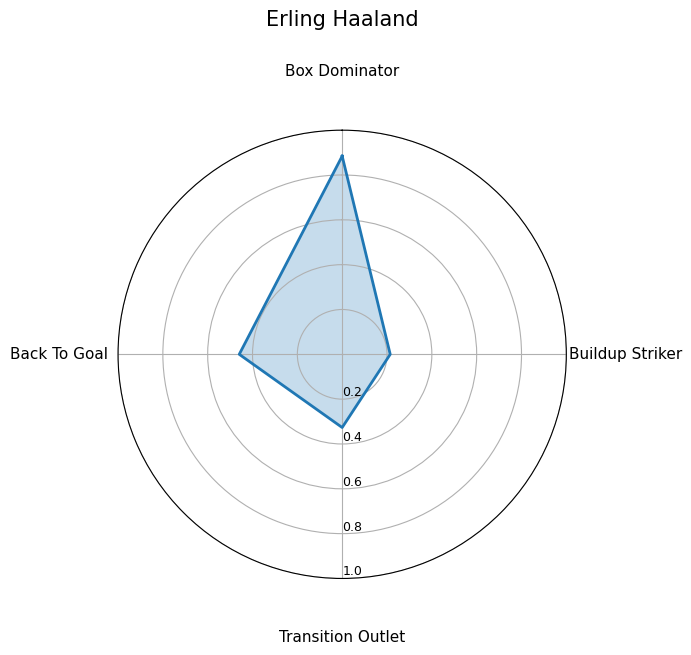

In [20]:
plot_player_radar(df, "Erling Haaland")

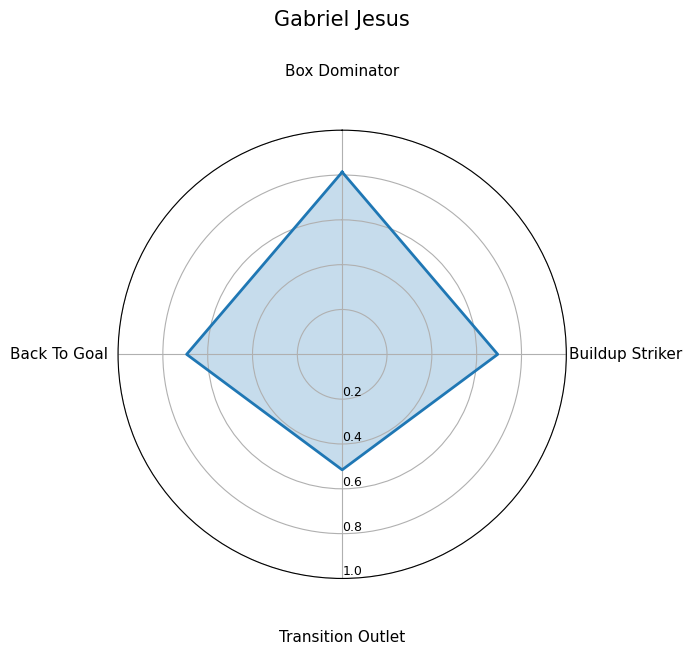

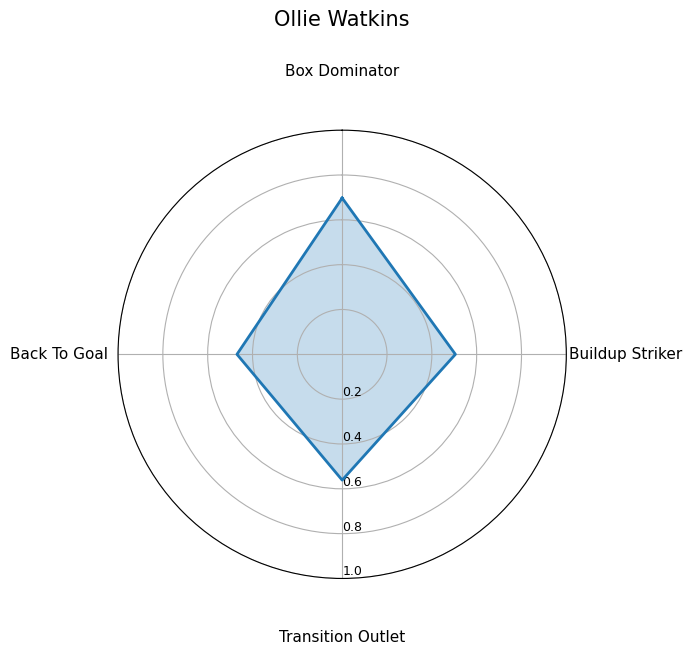

In [21]:
plot_player_radar(df, "Gabriel Jesus")
plot_player_radar(df, "Ollie Watkins")